# Lecture 4: Train/Test, Cross-Validation, and Regularization

In this notebook, we'll see how to create train/test splits in python.  We'll also see the `GridSearchCV` function, which is a very simple way to do cross-validation to select tuneable parameters.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
# this import is new
from sklearn.cross_validation import train_test_split
# this import is new
from sklearn.grid_search import GridSearchCV
import numpy as np
import pandas as pd

/Users/civisemployee/anaconda3/envs/civis/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/civisemployee/src/scikit-optimize/src/sklearn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/civisemployee/src/scikit-optimize/src/sklearn/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Let's read in the "Hitters" dataset from ISLR that has information on baseball players, their stats, and their salaries.  Also, we'll drop any rows with missing values.

In [3]:
hitters = pd.read_csv("./hitters.csv")
hitters = hitters.dropna(inplace=False)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We'll get rid of a few categorical columns rather than deal with converting them.  Then we'll create a binary variable for whether a player makes more than the median salary.

In [4]:
X = np.array(hitters.drop(["Salary", "League", "Division", "NewLeague"], axis=1))
y = (hitters["Salary"] >= np.median(hitters["Salary"])).astype("int")

Creating a training/testing split is extremely simple:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=10)

In [6]:
print(X_train.shape)
print(X_test.shape)

(184, 16)
(79, 16)


Next, we'll fit a logistic regression model to the training data and score the test data:

In [7]:
logit = LogisticRegression(penalty="l1", C=1e5)
logit.fit(X_train, y_train)

test_preds = logit.predict_proba(X_test)[:, 1]

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds)

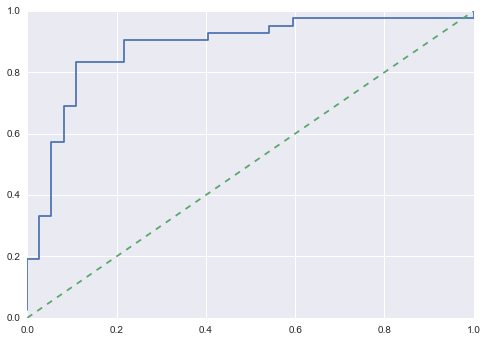

In [32]:
# we want to draw the random baseline ROC line too
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

plt.plot(fpr, tpr)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [9]:
roc_auc_score(y_test, test_preds)

0.88223938223938214

If we re-run the train/test split, we'll see the variability in this estimate.

We can use the test set (which, in this case, should really be called a validation set) to choose the best value of the tuneable parameter `C` of the logisitc regression, which is the inverse of $\lambda$, the regularization strength.

In [10]:
# create equally space values beteen 10^-10 and 10^10
c_vals = np.logspace(-10, 10, 20)

aucs = []
for c_val in c_vals:
    logit = LogisticRegression(C=c_val)
    logit.fit(X_train, y_train)

    test_preds = logit.predict_proba(X_test)[:, 1]
    aucs.append(roc_auc_score(y_test, test_preds))

In [35]:
aucs

[0.84877734877734889,
 0.84877734877734889,
 0.84555984555984565,
 0.8288288288288288,
 0.82303732303732302,
 0.87451737451737455,
 0.88545688545688539,
 0.85135135135135143,
 0.84555984555984554,
 0.86615186615186612,
 0.87644787644787636,
 0.88223938223938214,
 0.87773487773487779,
 0.8783783783783784,
 0.87966537966537972,
 0.88288288288288308,
 0.87773487773487768,
 0.8783783783783784,
 0.88352638352638357,
 0.88352638352638357]

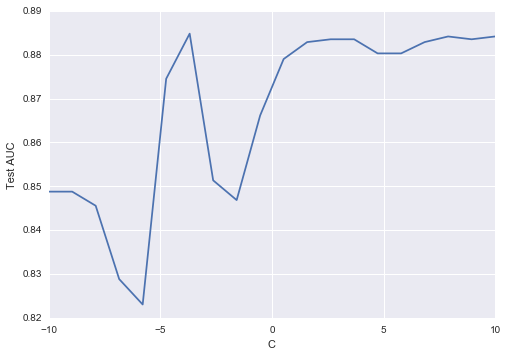

In [11]:
plt.plot(np.log10(c_vals), aucs)
plt.xlabel("C")
plt.ylabel("Test AUC")
plt.show()

Instead of using a train/test split, scikit-learn has a really nice way to use cross-validation to choose the tuneable parameters of a model.  First, we make a dictionary, where the key is the name of the parameter we want to tune (it has to match the name of the parameter in the model), and the values are the values we want to try:

In [12]:
param_grid = {"C": np.logspace(2, 8, 50)}

Then, we pass in the model we want to fit and the grid.  The option 'n_jobs' allows us to split the cross-validation over multiple cores of your computer, and `refit` tells it to fit the best performing model on the full dataset once it's done.

In [13]:
cv = GridSearchCV(logit, param_grid, cv=10, n_jobs=4, refit=True, verbose=True)
cv.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'C': array([  1.00000e+02,   1.32571e+02,   1.75751e+02,   2.32995e+02,
         3.08884e+02,   4.09492e+02,   5.42868e+02,   7.19686e+02,
         9.54095e+02,   1.26486e+03,   1.67683e+03,   2.22300e+03,
         2.94705e+03,   3.90694e+03,   5.17947e+03,   6.86649e+03,
         9.1029...    2.44205e+07,   3.23746e+07,   4.29193e+07,   5.68987e+07,
         7.54312e+07,   1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

We can see the best values and the grid scores:

In [14]:
cv.best_estimator_

LogisticRegression(C=175.75106248547911, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [15]:
cv.best_params_

{'C': 175.75106248547911}

Let's see what value of $\lambda$ corresponds to the best C:

In [16]:
np.log10(1.0/cv.best_params_['C'])

-2.2448979591836733

In [17]:
cv.best_score_

0.7989130434782609

In [18]:
cv.grid_scores_

[mean: 0.78804, std: 0.06866, params: {'C': 100.0},
 mean: 0.78804, std: 0.08342, params: {'C': 132.57113655901094},
 mean: 0.79891, std: 0.07723, params: {'C': 175.75106248547911},
 mean: 0.79348, std: 0.07812, params: {'C': 232.99518105153717},
 mean: 0.78261, std: 0.08213, params: {'C': 308.88435964774817},
 mean: 0.78804, std: 0.07566, params: {'C': 409.49150623804275},
 mean: 0.79891, std: 0.07871, params: {'C': 542.86754393238596},
 mean: 0.78261, std: 0.08213, params: {'C': 719.68567300115217},
 mean: 0.79891, std: 0.07723, params: {'C': 954.09547634999444},
 mean: 0.77717, std: 0.07129, params: {'C': 1264.8552168552958},
 mean: 0.77174, std: 0.07325, params: {'C': 1676.8329368110083},
 mean: 0.78804, std: 0.08342, params: {'C': 2222.9964825261955},
 mean: 0.79891, std: 0.07580, params: {'C': 2947.0517025518097},
 mean: 0.78261, std: 0.07424, params: {'C': 3906.9399370546171},
 mean: 0.78804, std: 0.06866, params: {'C': 5179.4746792312126},
 mean: 0.78804, std: 0.06700, params: 

In [19]:
test_preds = cv.best_estimator_.predict_proba(X_test)[:, 1]
test_preds

array([ 0.11296373,  0.10376148,  0.90836911,  0.03827043,  0.55081982,
        0.83092914,  0.19526386,  0.99804196,  0.05518466,  0.88293106,
        0.90843644,  0.08779142,  0.89978705,  0.21289901,  0.02629929,
        0.11051961,  0.71846671,  0.10471888,  0.44055646,  0.12408959,
        0.58654341,  0.9981192 ,  0.08863227,  0.04435924,  0.21087909,
        0.06041948,  0.83768706,  0.06096875,  0.17839043,  0.0436062 ,
        0.98499276,  0.99544269,  0.4869231 ,  0.34984886,  0.99878499,
        0.04173295,  0.99986049,  0.99747081,  0.98928548,  0.96213308,
        0.04159605,  0.26164902,  0.9979251 ,  0.37284471,  0.17232565,
        0.06538613,  0.45485268,  0.16529756,  0.72354255,  0.76511933,
        0.99338385,  0.68554182,  0.18959561,  0.98244778,  0.6510815 ,
        0.78765802,  0.82079819,  0.15772703,  0.98691473,  0.37192037,
        0.19315151,  0.04847812,  0.75264981,  0.03341367,  0.33400996,
        0.19805331,  0.12221995,  0.56253457,  0.81862771,  0.08

In [20]:
roc_auc_score(y_test, test_preds)

0.88352638352638346